# ivi Big Data school

## Pandas

### Получение данных

In [1]:
import json # читаем конфиги

import pandas as pd # гвоздь программы
import numpy as np # никогда не помешает немного numpy
from pyhive import presto # чтобы забрать данные

In [2]:
# визуализация
%matplotlib inline

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
!mkdir -p ./data
!ls | grep data

data


In [69]:
sql_string = """
SELECT
	cw.ivi_id
    ,op.name as operator_name
	,CASE WHEN c.compilation_id=898989 THEN c.id ELSE cmp.id END as content_id
	,CASE WHEN c.compilation_id=898989 THEN c.title ELSE cmp.title END as content_title
    ,cw.show_duration
FROM 
	groot.content_watch cw
INNER JOIN groot.content c
	on c.id = cw.content_id
INNER JOIN groot.operator op
	on op.id = operator_id
LEFT JOIN groot.compilation cmp
	on cmp.id = c.compilation_id
WHERE
	dt = '2017-08-01'
	AND subsite_id = 353
	AND NOT cw.ivi_id IS NULL
LIMIT 20000
"""

# загружаем данные для подключения из конфига
""""""
with open('../presto_config.json') as f:
    config = json.loads(f.read())

cursor = presto.connect(host=config["PRESTO_HOST"],
                        port=config["PRESTO_PORT"],
                        username=config["PRESTO_USER"]).cursor()

cursor.execute(sql_string)
data = cursor.fetchall()
# посмотрим на результат в страшном виде
print '"Сырые" данные:\n{}'.format(data[:3])
# сохраним в csv
with open('./content_watch.csv','w') as f:
    for i in data:
        f.write('\t'.join([
                    str(j.encode('utf-8')) 
                    if (type(j)<>int and not j is None)
                    else str(j) 
                for j in i]) + '\n'
        )

"Сырые" данные:
[[827375963, u'Rostelecom', 9966, u'\u041b\u0443\u043d\u0430', 1400], [890810589, u'LLC TOMTEL', 10140, u'\u0421\u043e\u043b\u0434\u0430\u0442\u044b', 1271], [929088258, u'OJS Moscow city telephone network', 9572, u'\u041c\u0430\u0436\u043e\u0440', 30]]


### Создание pandas DataFrame

Фреймы можно создавать двумя как из csv, так и из итерируемой последовательности "строк" будущей таблицы

In [4]:
col_names = ["user_id", "operator_name", "content_id", "content_title", "show_duration"]
# создаём фрейм из последовательности
#df_from_iterable = pd.DataFrame(data, columns=col_names)
#print(df_from_iterable.head(3))

# читаем из подготовленного csv
df = pd.read_csv('./content_watch.csv',
                 sep='\t',
                 header=None, # можно не передавать, если в файле есть заголовки столбцов
                 names = col_names)

#смотрим, что получилось
print('-'*10)
df.head(3)

----------


,user_id,operator_name,content_id,content_title,show_duration
0,827375963,Rostelecom,9966,Луна,1400
1,890810589,LLC TOMTEL,10140,Солдаты,1271
2,929088258,OJS Moscow city telephone network,9572,Мажор,30


Pandas - библиотека для работы с табличными данными, основные объекты Series (одномерный массив элементов фиксированного типа) и DataFrame (двумерный массив, тип данных однороден по колонкам)

### Первый взгляд на данные

вещи, которые пригодятся всегда

In [121]:
print(df.shape) # размерность таблички
print('-'*10)
print(df.columns) # имена колонок
print('-'*10)
print(df.info()) # информация о типах данных
# можно передать include=['object'] чтобы посчитать статиcтику по категориальным признакам
df.describe(percentiles=[])

(20000, 5)
----------
Index([u'user_id', u'operator_name', u'content_id', u'content_title',
       u'show_duration'],
      dtype='object')
----------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 5 columns):
user_id          20000 non-null int64
operator_name    20000 non-null object
content_id       20000 non-null int64
content_title    20000 non-null object
show_duration    20000 non-null object
dtypes: int64(2), object(3)
memory usage: 937.5+ KB
None


,user_id,content_id
count,2.000000e+04,20000.000000
mean,8.652511e+08,17391.642800
std,1.681163e+08,32636.639667
min,4.642900e+04,949.000000
50%,9.266323e+08,9525.000000
max,1.010558e+09,191504.000000


In [ ]:
# Тип колонки Pandas вычисляет автоматически - можно поменять на более актуальный
df['content_id'] = df['content_id'].astype('object')
df['user_id'] = df['user_id'].astype('object')

In [122]:
# сортировка данных - указать столбец сортировки
# можно так же указать несколько столбцов (составной ключ)
df.sort_values(by = 'show_duration', ascending=False).head(3)

,user_id,operator_name,content_id,content_title,show_duration
22,844887993,"OJSC Rostelecom, Vladimir branch",9797,Новые приключения Винни Пуха,None
31,767944789,OJSC RITC,9983,Метод,None
33,657807868,OJS Moscow city telephone network,10939,Район тьмы,None


#### Доступ к данным

как брать различные срезы данных

In [125]:
# Срез по колонкам 
col_slice = ['user_id', 'content_id']
# head - сколько строк DataFrame показать
df[col_slice].head(3)

,user_id,content_id
0,827375963,9966
1,890810589,10140
2,929088258,9572


In [34]:
# loc - индексация, основаная на названиях
# для slice используется стандартный синтаксис обхода питоновских коллекций START:END:STEP 
# отрицательный step - "листаем" в обратном порядке
df.loc[4:2:-2,col_slice]
# Индексы строк сейчас имеют целочисленный тип, но так будет не всегда
# df.loc[2:4, [0,2] ] - вызовет TypeError, т.к. для .loc колонки 2 не существует

,user_id,content_id
4,573841374,9983
2,929088258,9572


In [126]:
# для индексации по числовым индексам - iloc
df.iloc[4:2:-2, [2,3]]
# загадка - сколько строк будет в выводе?

,content_id,content_title
4,9983,Метод


### Очистка данных

"Сырые" данные напрямую из источников плохо пригодны для анализа. Очистить и подготовить данные можно с помощью Pаndas

.value_counts() - счетчик вхождения элементов в pandas.Series

In [127]:
# Почему show_duration имеет тип object?
print (df['show_duration'].value_counts().head(5)) # простая метрика - счётчик элементов. Считаем просмотры контента
# normalize=True - посчитаем доли объектов вместо абсолютных значений
print ("Доля None в колонке show_duration = {}".format(
        df['show_duration'].value_counts(normalize=True).head(1).values[0]))

None    2072
9        481
6        462
60       354
2        303
Name: show_duration, dtype: int64
Доля None в колонке show_duration = 0.1036


In [37]:
# Поменяем значение к колонке с помощью уже изученного loc - аналогично конструкции WHERE в SQL
df.loc[df['show_duration']=='None', 'show_duration'] = 0
# домашнее задание - сделать с помощью  другого метода pandas.DataFarame
df[df['show_duration']=='None'].head(5)
df['show_duration'] = df['show_duration'].astype('int')

In [38]:
# другой способ получить логический срез
df[df['content_id']==7029].head(3)
# df[df['content_id']==7029]['content_id'] = 7029 - так тоже попробуйте

,user_id,operator_name,content_id,content_title,show_duration
5943,603396239,Beeline Home,7029,ULU4SHAIZER,65
5946,985861659,Skynet Ltd,7029,ULU4SHAIZER,19
5947,958739701,VimpelCom,7029,ULU4SHAIZER,11


In [39]:
# можно строить срезы по нескольким условиям
df[(df.operator_name=='Beeline Home') &
   (df.content_title=='ULU4SHAIZER')].head(3)

,user_id,operator_name,content_id,content_title,show_duration
5943,603396239,Beeline Home,7029,ULU4SHAIZER,65
5961,788312739,Beeline Home,7029,ULU4SHAIZER,0
5967,1008874267,Beeline Home,7029,ULU4SHAIZER,126


In [40]:
# быстрый способ удалить строки - логический срез
df = df[df['content_id']!=7029]
df[df['content_id']==7029].head(3)

,user_id,operator_name,content_id,content_title,show_duration


### Агрегация данных

In [41]:
# Агрегаты можно вычислять по столбцам
print(df[['show_duration']].mean())
# можно добавить фильтрацию
print(df[df["operator_name"]=="Beeline Home"][['show_duration']].mean())

show_duration    1155.735311
dtype: float64
show_duration    1166.653368
dtype: float64


In [42]:
# как применить агрегирующую ко всем столбцам сразу - метод apply
df.apply(np.max)

user_id                 1010558449
operator_name      umos Center LLC
content_id                  191504
content_title    Я – телохранитель
show_duration                10184
dtype: object

In [44]:
# продвинутая агрегация, 
# синтаксис df.groupby(by=grouping_columns)[columns_to_show].agg(function())
df.groupby(by="user_id")["show_duration"].agg([np.mean, np.max, np.min]).head(3)

,mean,amax,amin
user_id,,,
46429,640.0,640,640
133989,2290.2,2874,15
234092,3085.0,3085,3085


### Сводные таблички

pd.crosstab - можно посмотреть на распределение информации в разрезе нескольких признаков

In [66]:
# рандомно раскидываем демографические маркеры
male_prob = 0.4
df["gender"] = np.random.binomial(1, male_prob, df.shape[0])
df.head(1)

,user_id,operator_name,content_id,content_title,show_duration,gender
0,827375963,Rostelecom,9966,Луна,1400,1


In [72]:
# основное применение apply - генерация новых фич
simple_df = pd.DataFrame({
    "gender" : df["gender"].apply(lambda x: 'male' if x==1 else 'female' ),
    "view_major" : df["content_title"].apply(lambda x: 'yes' if x=='Мажор' else 'no' )
})
simple_df.head(3)
pd.crosstab(simple_df["view_major"], simple_df["gender"])
# normalize=True - посчитает в долях

gender,female,male
view_major,,
no,11230,7427
yes,632,436


В pandas доступны сводные таблички

df.pivot_table([СТРОКИ], [СТОЛБЦЫ], [ЗНАЧЕНИЯ] aggfunc='АГГРЕГИРУЮЩАЯ ФУНКЦИЯ')

Для аггрегации можно использовать несколько колонок

In [112]:
gender_stat = pd.pivot_table(df,
                             index=['content_title'],
                             columns=['gender'],
                             values=['show_duration'],
                             aggfunc='mean')
gender_stat.head(3)

show_duration             
gender                     0            1
content_title                            
#SELFIEPARTY       61.000000          NaN
+1 (Плюс один)   2220.000000          NaN
1+1              1692.285714  2354.333333

In [113]:
# получили DataFrame
gender_stat.describe(percentiles=[])

show_duration             
gender             0            1
count     929.000000   767.000000
mean     1463.671299  1553.478662
std      1556.476612  1669.770242
min         0.000000     0.000000
50%      1088.800000  1090.000000
max      8575.000000  7565.000000

In [118]:
# отсортируем - что в среднем дольше всего сморят мужчины?
gender_stat.columns

MultiIndex(levels=[[u'show_duration'], [0, 1]],
           labels=[[0, 0], [0, 1]],
           names=[None, u'gender'])

In [115]:
gender_stat[[u'show_duration'][0]].sort_values(by=[0], ascending=False).head(1)

gender,0,1
content_title,,
За чужие грехи,8575,NaN


Отличие pivot_table от crosstab в том, что pivot_table применяется к DataFrame, а crosstab - к любой итерируемой последовательности.

## Визуализация данных

DataFrame.plot - мощный инструмент для визуализации, позволяет строить различные графики.

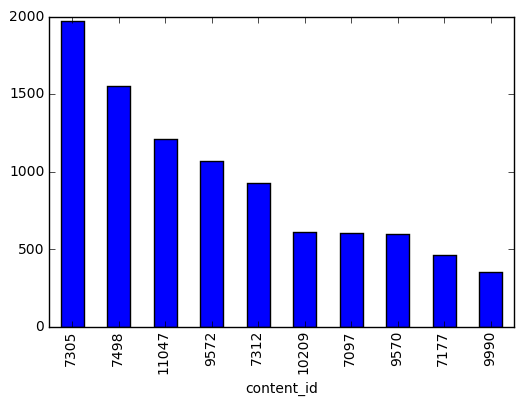

In [138]:
df.groupby(by="content_id")["user_id"]\
    .agg(np.count_nonzero)\
    .sort_values(ascending=False).head(10).plot(kind='bar')

## SQL-style: джойны

в pandas можно объединять разные DataFrame друг с другом в SQL-подобном стиле

In [145]:
print(df[['content_id', 'content_title']].shape)
content_info = df[['content_id', 'content_title']].drop_duplicates()
print(content_info.shape)
df.drop(['content_title'],axis=1, inplace=True)
df.head(3)
df.to_csv('./content_watch.csv', index=False)
df.to_csv('./content_watch.csv', index=False)

(20000, 2)
(1163, 2)


,user_id,operator_name,content_id,show_duration
0,827375963,Rostelecom,9966,1400
1,890810589,LLC TOMTEL,10140,1271
2,929088258,OJS Moscow city telephone network,9572,30


In [148]:
df.merge(content_info,
         how='inner',
         left_on='content_id',
         right_on='content_id').head(5)
# pd.concat - работает аналогично

,user_id,operator_name,content_id,show_duration,content_title
0,827375963,Rostelecom,9966,1400,Луна
1,895242481,Miranda-Media Ltd,9966,480,Луна
2,985001802,Rostelecom,9966,2760,Луна
3,857782037,Beeline Home,9966,2500,Луна
4,882781892,MTS OJSC,9966,720,Луна


# Домашнее задание

## Разминочная часть

In [ ]:
# Ваш код здесь


У какого оператора больше всего пользователей?


In [ ]:
# Ваш код здесь


Постройте любую визуализацию с помощью метода plot

In [ ]:
# Ваш код здесь


Какой средний показатель по числу просмотренных фильмов среди мужчин - пользователе Ростелекома?

In [ ]:
# Ваш код здесь


Построить по данным файла content_watch.csv матрицу user-item

В матрице должно быть 3 столбца

Первый столбец - user_id

Второй столбец - list из content_id, которые смотрел user_id. Оставлять нужно только уникальные id контента - повторов быть не должно


In [117]:
# Ваш код здесь
